# Curriculum Graph Analysis - Refactored

**Improvements:**
- Functions now **return graphs** instead of just displaying
- Separate **display functions** for flexibility
- **Hierarchical layout** support
- Better **AND/OR prerequisite logic** parsing
- Cleaner, more modular code structure

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import re
from typing import List, Dict, Tuple, Optional, Set

## 1. Data Loading and Cleaning

In [3]:
# Load data
data = pd.read_csv('curriculum_clean.csv')

# Clean prerequisites
data['Prerequisites'] = data['Prerequisites'].astype(str).str.strip().replace('NaN', np.nan)

print(f"Loaded {len(data)} course records")
print(f"Unique courses: {data['Course ID'].nunique()}")
print(f"Unique majors: {data['Major Title'].nunique()}")

Loaded 2661 course records
Unique courses: 205
Unique majors: 34


## 2. Enhanced Prerequisite Parsing

Handles AND/OR logic better than before

In [4]:
def extract_courses(prereq_str: str) -> List[str]:
    """
    Extract course codes from prerequisite string.
    Returns unique list of courses (removes duplicates from OR chains).
    
    Examples:
        "MTH 103 AND MTH 114" -> ['MTH 103', 'MTH 114']
        "MTH 103 OR MTH 116" -> ['MTH 103', 'MTH 116']
        "BS 161 OR BS 161 OR BS 161" -> ['BS 161']
    """
    if pd.isna(prereq_str):
        return []
    
    # Pattern to match course codes like "MTH 103", "CEM 161"
    courses = re.findall(r"[A-Z]{2,4}\s*\d{3}[A-Z]?", str(prereq_str))
    
    # Remove duplicates while preserving order
    return list(dict.fromkeys(courses))


def parse_prerequisite_logic(prereq_str: str) -> Dict:
    """
    Parse prerequisite string to identify AND/OR relationships.
    
    Returns:
        dict with keys:
            - 'courses': list of course codes
            - 'has_and': bool - contains AND logic
            - 'has_or': bool - contains OR logic
            - 'logic': str - 'AND', 'OR', 'MIXED', or 'SIMPLE'
    """
    if pd.isna(prereq_str):
        return {'courses': [], 'has_and': False, 'has_or': False, 'logic': 'SIMPLE'}
    
    prereq_str = str(prereq_str).upper()
    courses = extract_courses(prereq_str)
    
    has_and = ' AND ' in prereq_str
    has_or = ' OR ' in prereq_str
    
    # Determine logic type
    if has_and and has_or:
        logic = 'MIXED'
    elif has_and:
        logic = 'AND'
    elif has_or:
        logic = 'OR'
    else:
        logic = 'SIMPLE'
    
    return {
        'courses': courses,
        'has_and': has_and,
        'has_or': has_or,
        'logic': logic,
        'raw': prereq_str
    }


def split_and_or_groups(prereq_str: str) -> Dict[str, List[List[str]]]:
    """
    Advanced: Split prerequisites into AND groups and OR groups.
    
    Example:
        "(MTH 103 OR MTH 116) AND CEM 141" -> 
        {
            'and_groups': [['MTH 103', 'MTH 116'], ['CEM 141']],
            'required_all': ['CEM 141'],
            'required_one_of': [['MTH 103', 'MTH 116']]
        }
    """
    # This is a simplified version - can be enhanced for complex logic
    result = parse_prerequisite_logic(prereq_str)
    courses = result['courses']
    
    if result['logic'] == 'OR':
        return {
            'required_all': [],
            'required_one_of': [courses]
        }
    else:
        # For AND or MIXED, treat all as required
        return {
            'required_all': courses,
            'required_one_of': []
        }


# Test the functions
print("Testing prerequisite parsing:")
test_cases = [
    "MTH 103 AND MTH 114",
    "MTH 103 OR MTH 116",
    "BS 161 OR BS 161 OR BS 161",
    "(CEM 161 AND CEM 186H)",
    "MTH 103 OR MTH 103B"
]

for test in test_cases:
    result = parse_prerequisite_logic(test)
    print(f"\n{test}")
    print(f"  Courses: {result['courses']}")
    print(f"  Logic: {result['logic']}")

Testing prerequisite parsing:

MTH 103 AND MTH 114
  Courses: ['MTH 103', 'MTH 114']
  Logic: AND

MTH 103 OR MTH 116
  Courses: ['MTH 103', 'MTH 116']
  Logic: OR

BS 161 OR BS 161 OR BS 161
  Courses: ['BS 161']
  Logic: OR

(CEM 161 AND CEM 186H)
  Courses: ['CEM 161', 'CEM 186H']
  Logic: AND

MTH 103 OR MTH 103B
  Courses: ['MTH 103', 'MTH 103B']
  Logic: OR


In [5]:
# Apply enhanced parsing to data
data['Cleaned_Prereqs'] = data['Prerequisites'].apply(extract_courses)
data['Prereq_Logic'] = data['Prerequisites'].apply(parse_prerequisite_logic)

print("Prerequisite logic analysis:")
print(data['Prereq_Logic'].apply(lambda x: x['logic']).value_counts())

Prerequisite logic analysis:
Prereq_Logic
SIMPLE    1809
OR         466
AND        386
Name: count, dtype: int64


## 3. Graph Building Functions (NOW RETURN GRAPHS!)

**Key Change:** Functions return graph objects instead of just displaying

In [6]:
def build_full_graph(data_df: pd.DataFrame) -> nx.DiGraph:
    """
    Build a directed graph of ALL courses in the dataset.
    
    Returns:
        NetworkX DiGraph with course nodes and prerequisite edges
    """
    G = nx.DiGraph()
    
    # Add nodes with attributes
    for _, row in data_df.iterrows():
        course_id = row['Course ID']
        
        # Skip invalid courses
        if pd.isna(course_id) or course_id == 'Electives':
            continue
        
        G.add_node(
            course_id,
            name=row['Course Name'],
            major=row['Major Code'],
            major_title=row['Major Title'],
            year=row['Year Level'],
            term=row['Term Season'],
            credits=row['Credits'],
            has_prereq=row['Has Prerequisites']
        )
    
    # Add edges (prerequisite relationships)
    for _, row in data_df.iterrows():
        course = row['Course ID']
        if course not in G.nodes():
            continue
            
        prereqs = row['Cleaned_Prereqs']
        prereq_logic = row['Prereq_Logic']
        
        for prereq in prereqs:
            if prereq in G.nodes():
                # Add edge with logic type as attribute
                G.add_edge(
                    prereq, 
                    course,
                    logic=prereq_logic['logic']
                )
    
    return G


def build_major_graph(data_df: pd.DataFrame, major: str) -> Optional[nx.DiGraph]:
    """
    Build a graph for a specific major.
    
    Args:
        data_df: Course data
        major: Major title to filter by
    
    Returns:
        NetworkX DiGraph for the major, or None if major not found
    """
    # Validate major
    majors = data_df['Major Title'].unique()
    if major not in majors:
        return None
    
    # Build full graph first
    G = build_full_graph(data_df)
    
    # Get courses for this major
    major_courses = data_df[data_df['Major Title'] == major]['Course ID'].unique()
    
    # Create subgraph
    subgraph = G.subgraph(major_courses).copy()
    
    return subgraph


def build_course_graph(data_df: pd.DataFrame, course_id: str, depth: int = 2) -> Optional[nx.DiGraph]:
    """
    Build a graph centered on a specific course, showing prerequisites and dependents.
    
    Args:
        data_df: Course data
        course_id: Course to center on
        depth: How many levels of prerequisites/dependents to include
    
    Returns:
        NetworkX DiGraph centered on the course
    """
    # Build full graph
    G = build_full_graph(data_df)
    
    if course_id not in G.nodes():
        return None
    
    # Get nodes within depth
    nodes_to_include = {course_id}
    
    # Add predecessors (prerequisites)
    for _ in range(depth):
        new_nodes = set()
        for node in nodes_to_include:
            new_nodes.update(G.predecessors(node))
        nodes_to_include.update(new_nodes)
    
    # Add successors (courses that depend on this)
    for _ in range(depth):
        new_nodes = set()
        for node in nodes_to_include:
            new_nodes.update(G.successors(node))
        nodes_to_include.update(new_nodes)
    
    # Create subgraph
    subgraph = G.subgraph(nodes_to_include).copy()
    
    return subgraph


def build_department_graph(data_df: pd.DataFrame, dept_code: str) -> Optional[nx.DiGraph]:
    """
    Build a graph for all courses in a specific department.
    
    Args:
        data_df: Course data
        dept_code: Department code (e.g., 'MTH', 'CEM')
    
    Returns:
        NetworkX DiGraph for the department
    """
    G = build_full_graph(data_df)
    
    # Filter courses by department
    dept_courses = [node for node in G.nodes() 
                    if str(node).startswith(dept_code.upper())]
    
    if not dept_courses:
        return None
    
    subgraph = G.subgraph(dept_courses).copy()
    return subgraph


print("✓ Graph building functions defined")

✓ Graph building functions defined


## 4. Display Functions (Separate from Graph Building)

**Key Change:** Display is now separate - you can build graph once, display many ways

In [7]:
def display_graph_basic(G: nx.DiGraph, title: str = "Course Graph", figsize: Tuple = (12, 8)):
    """
    Basic graph display with spring layout.
    
    Args:
        G: NetworkX graph to display
        title: Graph title
        figsize: Figure size
    """
    plt.figure(figsize=figsize)
    
    # Spring layout
    pos = nx.spring_layout(G, k=0.5, iterations=50)
    
    # Draw
    nx.draw(
        G, pos,
        with_labels=True,
        node_size=500,
        node_color='lightblue',
        font_size=8,
        font_weight='bold',
        arrows=True,
        edge_color='gray',
        arrowsize=10
    )
    
    plt.title(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


def display_graph_hierarchical(G: nx.DiGraph, title: str = "Course Graph (Hierarchical)", 
                                figsize: Tuple = (16, 10)):
    """
    Display graph with HIERARCHICAL layout (left to right).
    Shows prerequisite flow clearly.
    
    Args:
        G: NetworkX graph to display
        title: Graph title
        figsize: Figure size
    """
    plt.figure(figsize=figsize)
    
    # Check if graph is a DAG
    if not nx.is_directed_acyclic_graph(G):
        print("Warning: Graph contains cycles. Hierarchical layout may not be ideal.")
    
    try:
        # Try hierarchical layout
        pos = nx.nx_agraph.graphviz_layout(G, prog='dot', args='-Grankdir=LR')
    except:
        # Fallback to shell layout if graphviz not available
        print("Graphviz not available, using shell layout")
        pos = nx.shell_layout(G)
    
    # Color nodes by out-degree (importance)
    node_colors = []
    for node in G.nodes():
        out_deg = G.out_degree(node)
        if out_deg >= 5:
            node_colors.append('#e74c3c')  # Red - very important
        elif out_deg >= 2:
            node_colors.append('#f39c12')  # Orange - important
        else:
            node_colors.append('#3498db')  # Blue - basic
    
    # Draw
    nx.draw(
        G, pos,
        with_labels=True,
        node_size=600,
        node_color=node_colors,
        font_size=9,
        font_weight='bold',
        arrows=True,
        edge_color='#7f8c8d',
        arrowsize=12,
        arrowstyle='->',
        width=2
    )
    
    plt.title(title, fontsize=16, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()


def display_graph_with_and_or(G: nx.DiGraph, title: str = "Course Graph with Logic",
                               figsize: Tuple = (14, 10)):
    """
    Display graph with different edge styles for AND/OR logic.
    
    - Solid lines = AND prerequisites (all required)
    - Dashed lines = OR prerequisites (one of many required)
    
    Args:
        G: NetworkX graph to display
        title: Graph title
        figsize: Figure size
    """
    plt.figure(figsize=figsize)
    
    # Layout
    pos = nx.spring_layout(G, k=0.5, iterations=50)
    
    # Separate edges by logic type
    and_edges = [(u, v) for u, v, d in G.edges(data=True) 
                 if d.get('logic') in ['AND', 'SIMPLE']]
    or_edges = [(u, v) for u, v, d in G.edges(data=True) 
                if d.get('logic') == 'OR']
    mixed_edges = [(u, v) for u, v, d in G.edges(data=True) 
                   if d.get('logic') == 'MIXED']
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=500, node_color='lightblue')
    nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold')
    
    # Draw AND edges (solid)
    nx.draw_networkx_edges(G, pos, edgelist=and_edges, 
                           edge_color='black', style='solid', arrows=True,
                           arrowsize=10, width=2)
    
    # Draw OR edges (dashed)
    nx.draw_networkx_edges(G, pos, edgelist=or_edges,
                           edge_color='blue', style='dashed', arrows=True,
                           arrowsize=10, width=2)
    
    # Draw MIXED edges (dotted)
    nx.draw_networkx_edges(G, pos, edgelist=mixed_edges,
                           edge_color='red', style='dotted', arrows=True,
                           arrowsize=10, width=2)
    
    plt.title(title, fontsize=14, fontweight='bold')
    
    # Add legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='black', linewidth=2, label='AND (all required)'),
        Line2D([0], [0], color='blue', linewidth=2, linestyle='--', label='OR (one of)'),
        Line2D([0], [0], color='red', linewidth=2, linestyle=':', label='MIXED')
    ]
    plt.legend(handles=legend_elements, loc='upper right')
    
    plt.axis('off')
    plt.tight_layout()
    plt.show()


def print_graph_stats(G: nx.DiGraph, name: str = "Graph"):
    """
    Print statistics about a graph.
    
    Args:
        G: NetworkX graph
        name: Name for the graph
    """
    print(f"\n{'='*60}")
    print(f"{name} Statistics")
    print(f"{'='*60}")
    print(f"Nodes (courses): {G.number_of_nodes()}")
    print(f"Edges (prerequisites): {G.number_of_edges()}")
    print(f"Is DAG: {nx.is_directed_acyclic_graph(G)}")
    
    if G.number_of_nodes() > 0:
        # Degree statistics
        in_degrees = [d for n, d in G.in_degree()]
        out_degrees = [d for n, d in G.out_degree()]
        
        print(f"\nDegree Statistics:")
        print(f"  Avg prerequisites per course: {np.mean(in_degrees):.2f}")
        print(f"  Avg courses unlocked: {np.mean(out_degrees):.2f}")
        print(f"  Max prerequisites: {max(in_degrees)}")
        print(f"  Max courses unlocked: {max(out_degrees)}")
        
        # Top bottleneck courses
        top_bottlenecks = sorted(G.out_degree(), key=lambda x: x[1], reverse=True)[:5]
        print(f"\nTop Bottleneck Courses:")
        for course, count in top_bottlenecks:
            if count > 0:
                print(f"  {course}: unlocks {count} courses")
    
    print(f"{'='*60}\n")


print("✓ Display functions defined")

✓ Display functions defined


## 5. Helper Functions for User Interaction

In [8]:
def list_majors(data_df: pd.DataFrame):
    """Print list of available majors."""
    majors = sorted(data_df['Major Title'].unique())
    print("Available Majors:")
    for i, major in enumerate(majors, 1):
        print(f"  {i}. {major}")
    return majors


def find_majors_by_course(data_df: pd.DataFrame, course_code: str):
    """
    Find which majors include a specific course.
    
    Args:
        data_df: Course data
        course_code: Course ID to search for
    """
    matches = data_df[data_df['Course ID'].str.lower() == course_code.lower()]
    
    if matches.empty:
        print(f"Course '{course_code}' not found.")
        return []
    
    majors = matches['Major Title'].unique()
    print(f"\nCourse {course_code} appears in {len(majors)} major(s):")
    for major in sorted(majors):
        print(f"  - {major}")
    
    return list(majors)


def list_departments(data_df: pd.DataFrame):
    """List all departments in the data."""
    # Extract department codes from course IDs
    dept_codes = set()
    for course_id in data_df['Course ID'].unique():
        match = re.match(r'^([A-Z]{2,4})', str(course_id))
        if match:
            dept_codes.add(match.group(1))
    
    print("Departments found:")
    for dept in sorted(dept_codes):
        count = len([c for c in data_df['Course ID'].unique() if str(c).startswith(dept)])
        print(f"  {dept}: {count} courses")
    
    return sorted(dept_codes)


print("✓ Helper functions defined")

✓ Helper functions defined


## 6. Usage Examples

Now you can **build once, display many ways**!

In [9]:
# Example 1: Build full graph and display it different ways
print("Building full curriculum graph...")
full_graph = build_full_graph(data)

# Display stats
print_graph_stats(full_graph, "Full Curriculum")

# Note: Full graph is too large to display nicely
# Better to use major/department subgraphs

Building full curriculum graph...

Full Curriculum Statistics
Nodes (courses): 205
Edges (prerequisites): 151
Is DAG: True

Degree Statistics:
  Avg prerequisites per course: 0.74
  Avg courses unlocked: 0.74
  Max prerequisites: 4
  Max courses unlocked: 13

Top Bottleneck Courses:
  BS 161: unlocks 13 courses
  BS 162: unlocks 11 courses
  CEM 142: unlocks 10 courses
  MTH 133: unlocks 7 courses
  CEM 141: unlocks 6 courses




Statistics, BA Statistics
Nodes (courses): 21
Edges (prerequisites): 8
Is DAG: True

Degree Statistics:
  Avg prerequisites per course: 0.38
  Avg courses unlocked: 0.38
  Max prerequisites: 1
  Max courses unlocked: 3

Top Bottleneck Courses:
  MTH 103: unlocks 3 courses
  MTH 133: unlocks 2 courses
  MTH 132: unlocks 1 courses
  MTH 234: unlocks 1 courses
  MTH 309: unlocks 1 courses



/tmp/ipykernel_3215053/4065677427.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


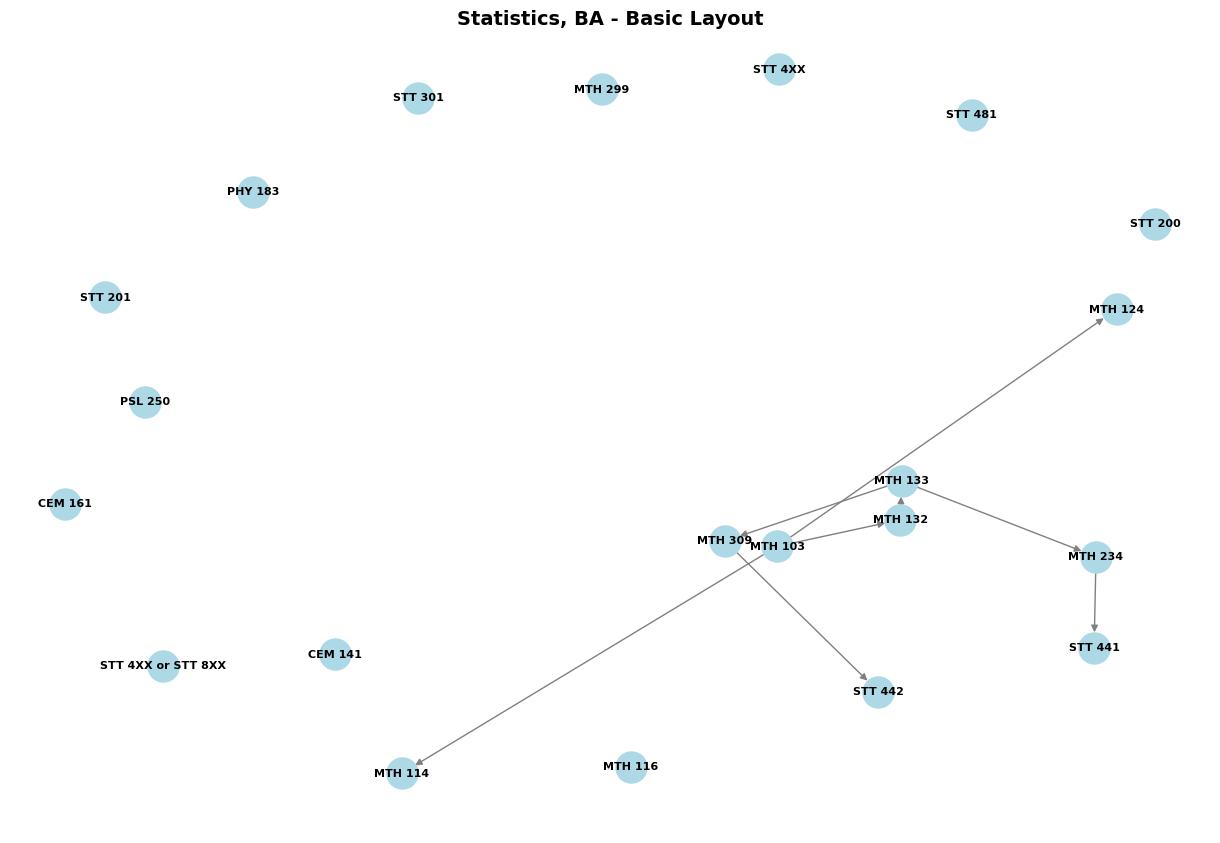

Graphviz not available, using shell layout


/tmp/ipykernel_3215053/4065677427.py:86: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


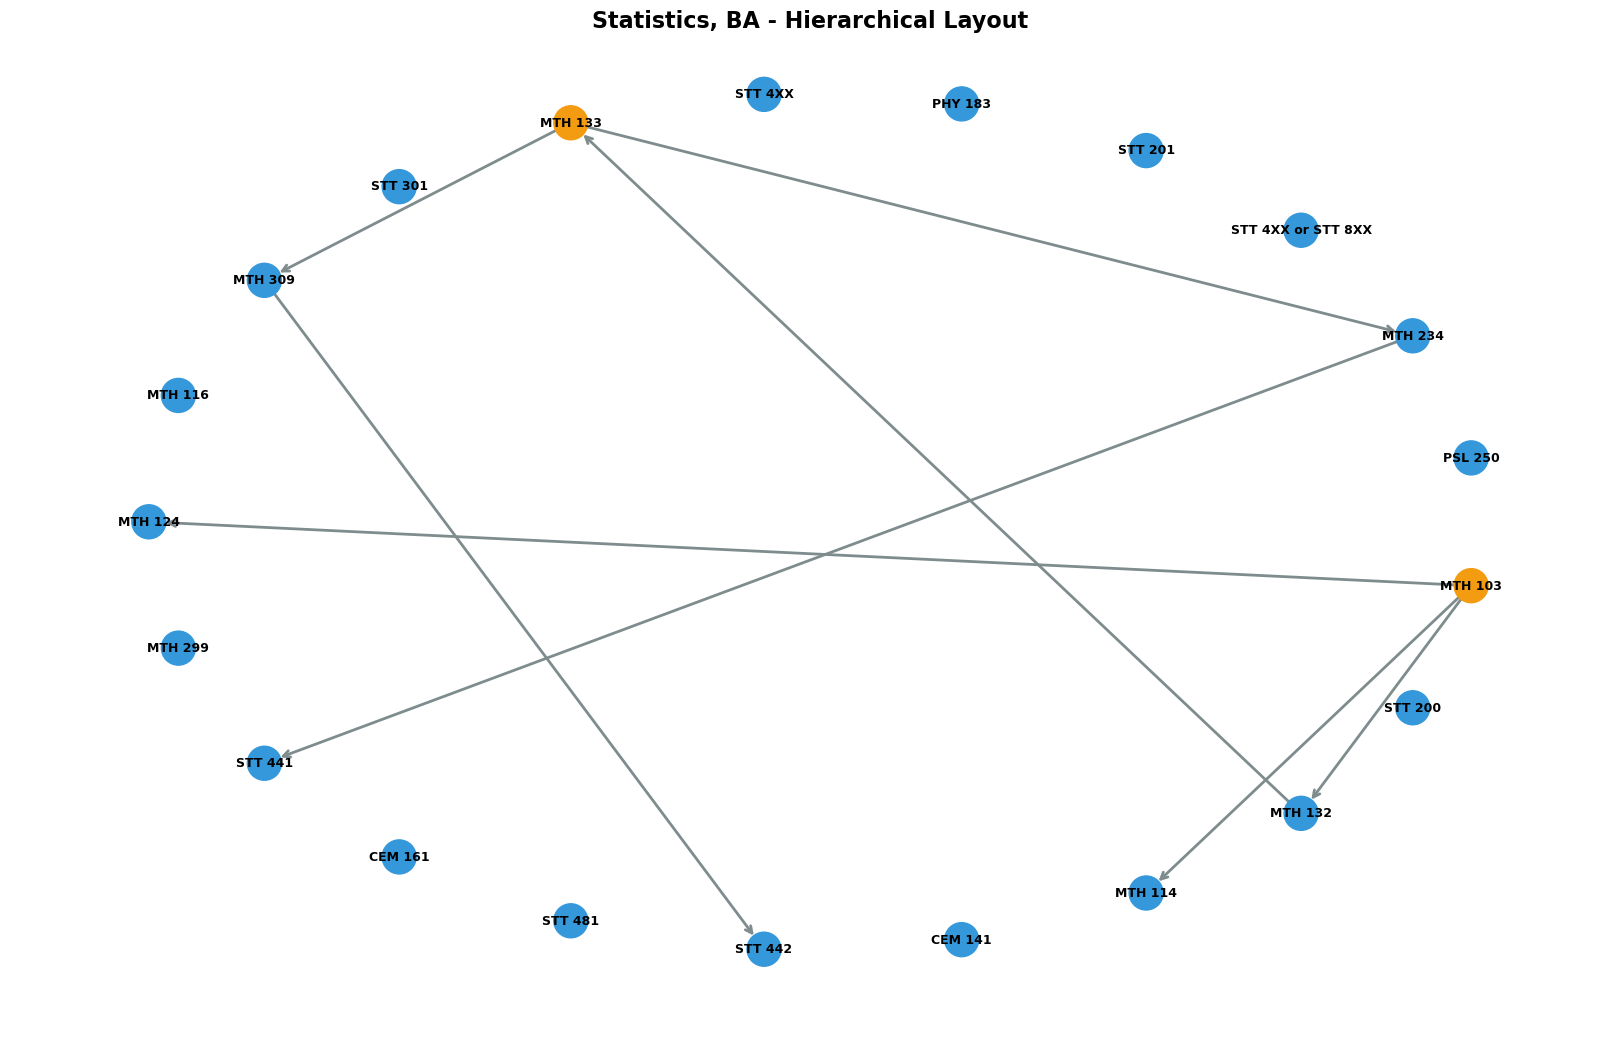

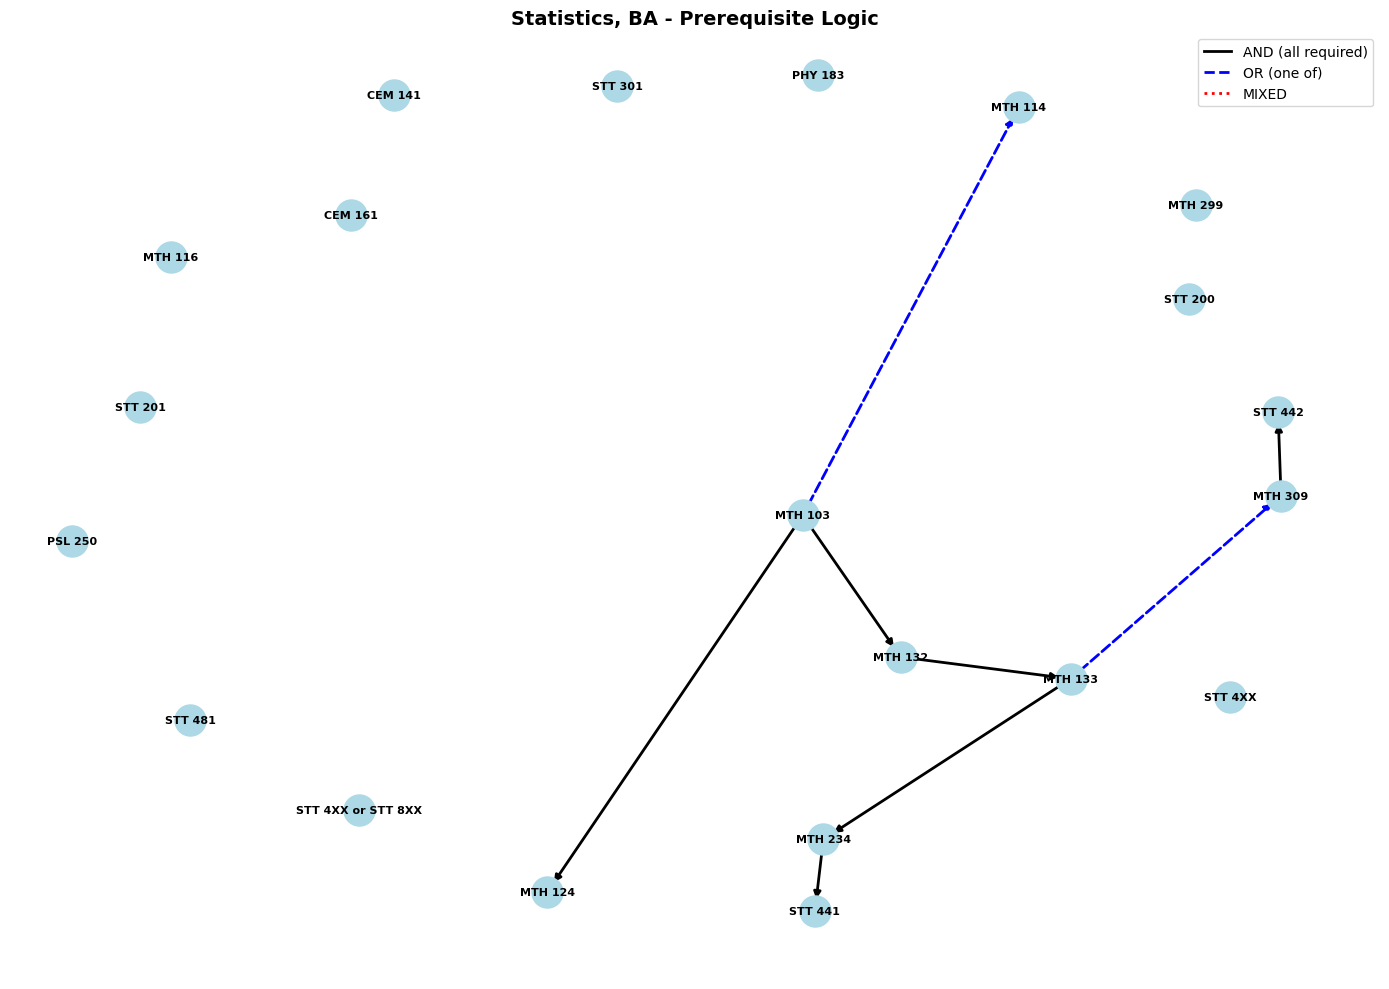

In [10]:
# Example 2: Build graph for a specific major
major = 'Statistics, BA'

# Build graph (returns graph object)
stats_graph = build_major_graph(data, major)

if stats_graph:
    # Print statistics
    print_graph_stats(stats_graph, f"{major}")
    
    # Display with basic layout
    display_graph_basic(stats_graph, f"{major} - Basic Layout")
    
    # Display with hierarchical layout
    display_graph_hierarchical(stats_graph, f"{major} - Hierarchical Layout")
    
    # Display with AND/OR logic
    display_graph_with_and_or(stats_graph, f"{major} - Prerequisite Logic")
else:
    print(f"Major '{major}' not found")
    list_majors(data)


MTH Department Statistics
Nodes (courses): 40
Edges (prerequisites): 25
Is DAG: True

Degree Statistics:
  Avg prerequisites per course: 0.62
  Avg courses unlocked: 0.62
  Max prerequisites: 3
  Max courses unlocked: 5

Top Bottleneck Courses:
  MTH 133: unlocks 5 courses
  MTH 153H: unlocks 5 courses
  MTH 103: unlocks 3 courses
  MTH 309: unlocks 3 courses
  MTH 299: unlocks 2 courses

Graphviz not available, using shell layout


/tmp/ipykernel_3215053/4065677427.py:86: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


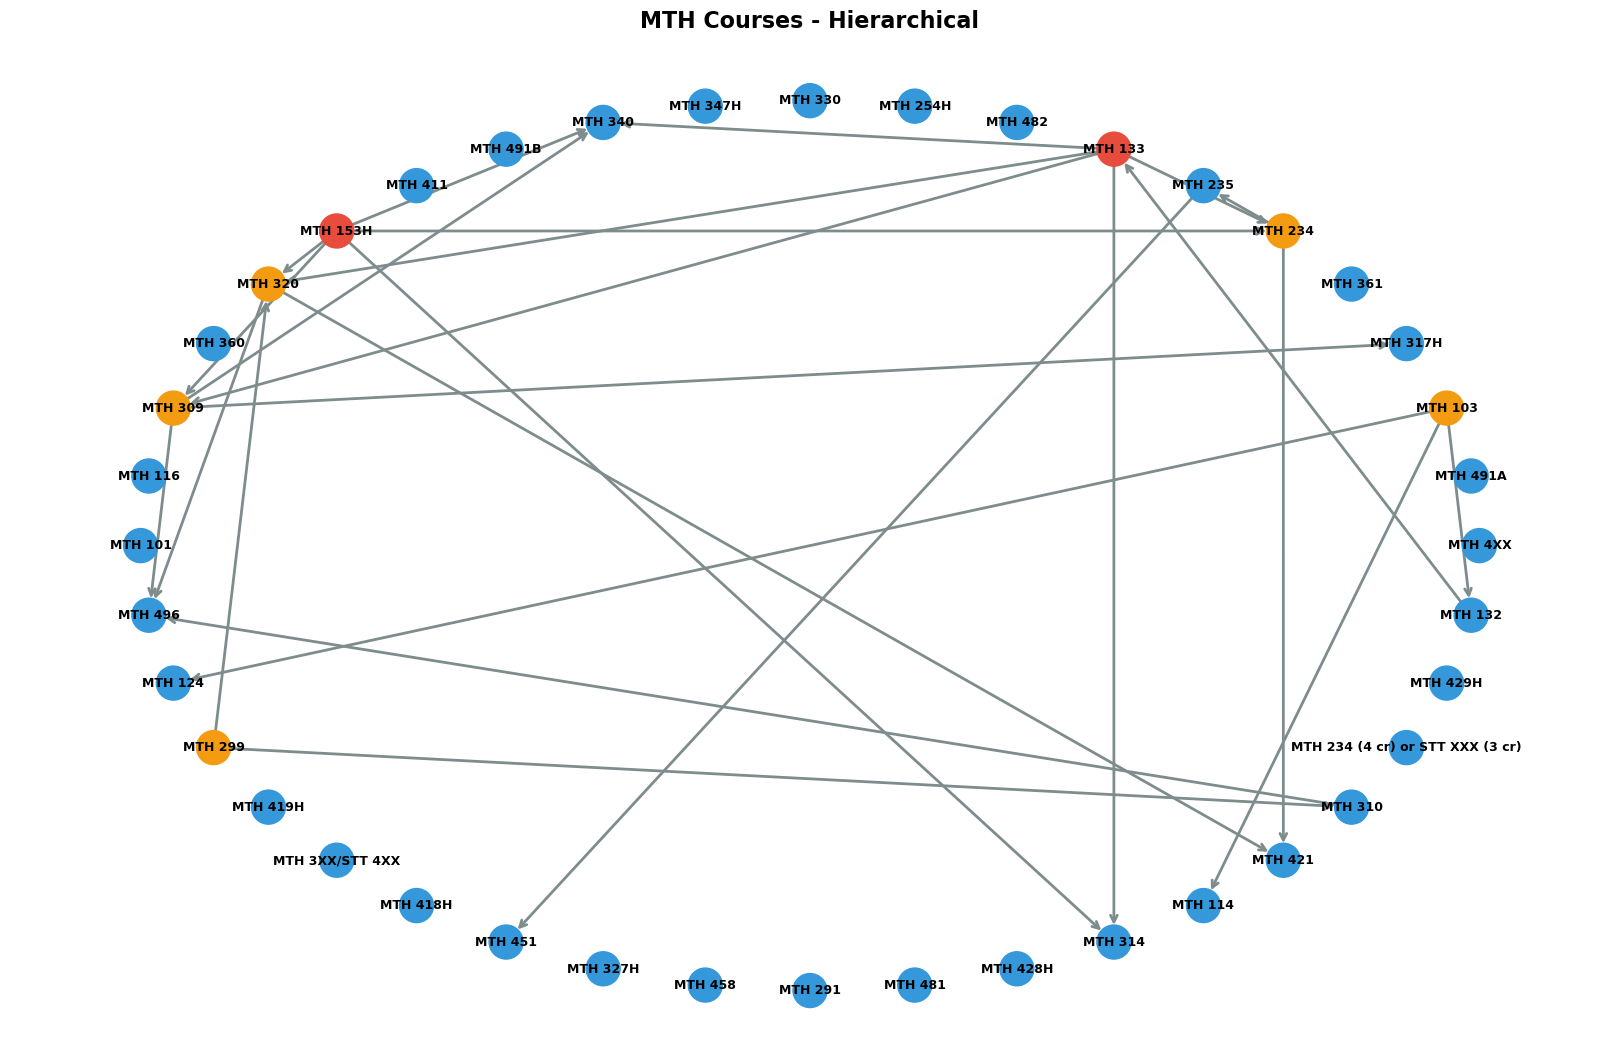

In [11]:
# Example 3: Build graph for a department
dept = 'MTH'

math_graph = build_department_graph(data, dept)

if math_graph:
    print_graph_stats(math_graph, f"{dept} Department")
    display_graph_hierarchical(math_graph, f"{dept} Courses - Hierarchical")
else:
    print(f"Department '{dept}' not found")
    list_departments(data)


Graph centered on MTH 133 Statistics
Nodes (courses): 28
Edges (prerequisites): 31
Is DAG: True

Degree Statistics:
  Avg prerequisites per course: 1.11
  Avg courses unlocked: 1.11
  Max prerequisites: 2
  Max courses unlocked: 7

Top Bottleneck Courses:
  MTH 133: unlocks 7 courses
  MTH 234: unlocks 5 courses
  MTH 103: unlocks 4 courses
  MTH 309: unlocks 4 courses
  MTH 124: unlocks 3 courses

Graphviz not available, using shell layout


/tmp/ipykernel_3215053/4065677427.py:86: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


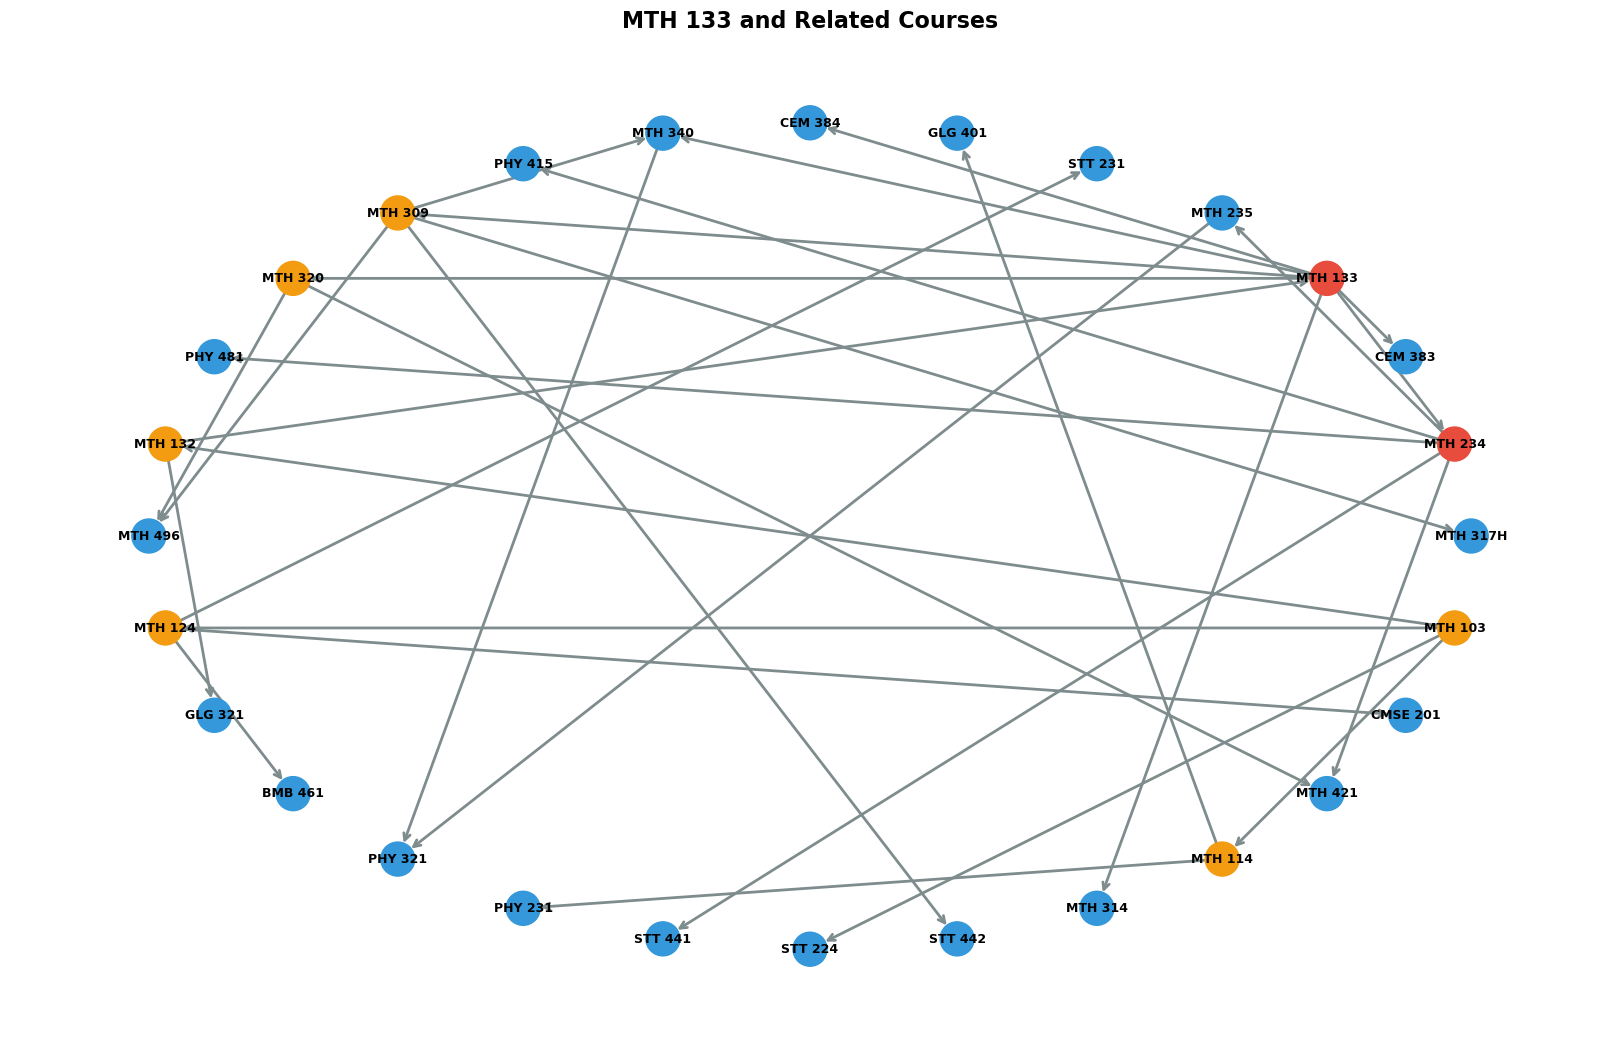

In [12]:
# Example 4: Build graph centered on a specific course
course = 'MTH 133'

course_graph = build_course_graph(data, course, depth=2)

if course_graph:
    print_graph_stats(course_graph, f"Graph centered on {course}")
    display_graph_hierarchical(course_graph, f"{course} and Related Courses")
else:
    print(f"Course '{course}' not found")

## 7. Advanced Analysis

Now that functions return graphs, you can analyze them!

In [13]:
# Build a graph for analysis
G = build_major_graph(data, 'Chemistry')

if G:
    print("Analysis of Chemistry Major:\n")
    
    # Find longest prerequisite chain
    if nx.is_directed_acyclic_graph(G):
        longest_path = nx.dag_longest_path(G)
        print(f"Longest prerequisite chain ({len(longest_path)} courses):")
        print(" → ".join(longest_path))
    
    # Find most central courses
    print("\nMost central courses (betweenness centrality):")
    centrality = nx.betweenness_centrality(G)
    top_central = sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:5]
    for course, score in top_central:
        print(f"  {course}: {score:.3f}")
    
    # Find courses with no prerequisites (entry points)
    entry_points = [n for n in G.nodes() if G.in_degree(n) == 0]
    print(f"\nEntry point courses (no prerequisites): {len(entry_points)}")
    print(", ".join(entry_points[:10]))
    
    # Find terminal courses (not prerequisites for anything)
    terminal = [n for n in G.nodes() if G.out_degree(n) == 0]
    print(f"\nTerminal courses (not required for anything): {len(terminal)}")
    print(", ".join(terminal[:10]))

Analysis of Chemistry Major:

Longest prerequisite chain (8 courses):
CEM 181H → CEM 151 → CEM 152 → CEM 142 → CEM 483 → CEM 395 → CEM 434 → CEM 435

Most central courses (betweenness centrality):
  CEM 142: 0.038
  CEM 483: 0.021
  CEM 151: 0.021
  CEM 395: 0.017
  CEM 152: 0.015

Entry point courses (no prerequisites): 15
PHY 232, PHY 251, PHY 231, CEM 161, CEM 356, PHY 191, CEM 181H, CEM 252, CEM 185H, PHY 183

Terminal courses (not required for anything): 22
PHY 232, CEM 415, CEM 444, PHY 251, CEM 356, BMB 401, CEM 352, CEM 495, CEM 185H, CEM 435


## 8. Compare Multiple Majors

In [14]:
# Compare two majors
major1 = 'Chemistry'
major2 = 'Physics'

G1 = build_major_graph(data, major1)
G2 = build_major_graph(data, major2)

if G1 and G2:
    print(f"Comparison: {major1} vs {major2}\n")
    print(f"{major1}:")
    print(f"  Courses: {G1.number_of_nodes()}")
    print(f"  Prerequisites: {G1.number_of_edges()}")
    print(f"  Avg prerequisites/course: {G1.number_of_edges() / G1.number_of_nodes():.2f}")
    
    print(f"\n{major2}:")
    print(f"  Courses: {G2.number_of_nodes()}")
    print(f"  Prerequisites: {G2.number_of_edges()}")
    print(f"  Avg prerequisites/course: {G2.number_of_edges() / G2.number_of_nodes():.2f}")
    
    # Find shared courses
    shared = set(G1.nodes()) & set(G2.nodes())
    print(f"\nShared courses: {len(shared)}")
    if shared:
        print(", ".join(list(shared)[:10]))

## 9. Interactive Exploration

Use these cells to explore your data interactively

In [15]:
# List all available majors
majors = list_majors(data)

Available Majors:
  1. Actuarial Science, BS
  2. Astrophysics
  3. Biochem&Molecular Biol/Biotech, BS
  4. Biochemistry & Molecular Biol, BS
  5. Biological Science-Interdept
  6. Biological Science-Interdept, BS
  7. Biomedical Laboratory Science, BS
  8. Chemical Physics, BS
  9. Chemistry
  10. Chemistry, BA
  11. Computational Mathematics, BA
  12. Computational Mathematics, BS
  13. Environ Biology/Microbiology, BS
  14. Environmental Biol/Plant Biol, BS
  15. Environmental Biology/Zoology, BS
  16. Environmental Geosciences, BS
  17. Genomics & Molecular Genetics, BS
  18. Geological Sciences, BS
  19. Human Biology
  20. Integrative Biology, BS
  21. Mathematics, Advanced
  22. Mathematics, BA
  23. Mathematics, BS
  24. Microbiology, BS
  25. Neuroscience, BS
  26. Physical Science
  27. Physics, BA
  28. Physics, BS
  29. Physiology, BS
  30. Plant Biology, BS
  31. Statistics, BA
  32. Statistics, BS
  33. Zoology, BA
  34. Zoology, BS


In [16]:
# List all departments
departments = list_departments(data)

Departments found:
  AST: 4 courses
  BLD: 12 courses
  BMB: 8 courses
  BS: 4 courses
  CEM: 33 courses
  CMSE: 1 courses
  GLG: 11 courses
  IBIO: 18 courses
  ISE: 2 courses
  MMG: 11 courses
  MTH: 40 courses
  NEU: 4 courses
  NSC: 1 courses
  PHY: 20 courses
  PLB: 8 courses
  PSL: 9 courses
  PSY: 1 courses
  STT: 14 courses
  TE: 4 courses


In [17]:
# Find which majors include a course
find_majors_by_course(data, 'MTH 133')


Course MTH 133 appears in 19 major(s):
  - Actuarial Science, BS
  - Astrophysics
  - Biochem&Molecular Biol/Biotech, BS
  - Biochemistry & Molecular Biol, BS
  - Biological Science-Interdept, BS
  - Chemical Physics, BS
  - Chemistry
  - Chemistry, BA
  - Computational Mathematics, BA
  - Computational Mathematics, BS
  - Environmental Geosciences, BS
  - Geological Sciences, BS
  - Mathematics, BA
  - Mathematics, BS
  - Physical Science
  - Physics, BA
  - Physics, BS
  - Statistics, BA
  - Statistics, BS


['Chemistry, BA',
 'Chemistry',
 'Mathematics, BS',
 'Mathematics, BA',
 'Computational Mathematics, BA',
 'Computational Mathematics, BS',
 'Biological Science-Interdept, BS',
 'Physical Science',
 'Astrophysics',
 'Chemical Physics, BS',
 'Physics, BA',
 'Physics, BS',
 'Statistics, BA',
 'Statistics, BS',
 'Geological Sciences, BS',
 'Environmental Geosciences, BS',
 'Biochemistry & Molecular Biol, BS',
 'Biochem&Molecular Biol/Biotech, BS',
 'Actuarial Science, BS']


Integrative Biology, BS Statistics
Nodes (courses): 23
Edges (prerequisites): 10
Is DAG: True

Degree Statistics:
  Avg prerequisites per course: 0.43
  Avg courses unlocked: 0.43
  Max prerequisites: 2
  Max courses unlocked: 3

Top Bottleneck Courses:
  BS 162: unlocks 3 courses
  BS 161: unlocks 2 courses
  MTH 103: unlocks 2 courses
  CEM 161: unlocks 1 courses
  CEM 252: unlocks 1 courses

Graphviz not available, using shell layout


/tmp/ipykernel_3215053/4065677427.py:86: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


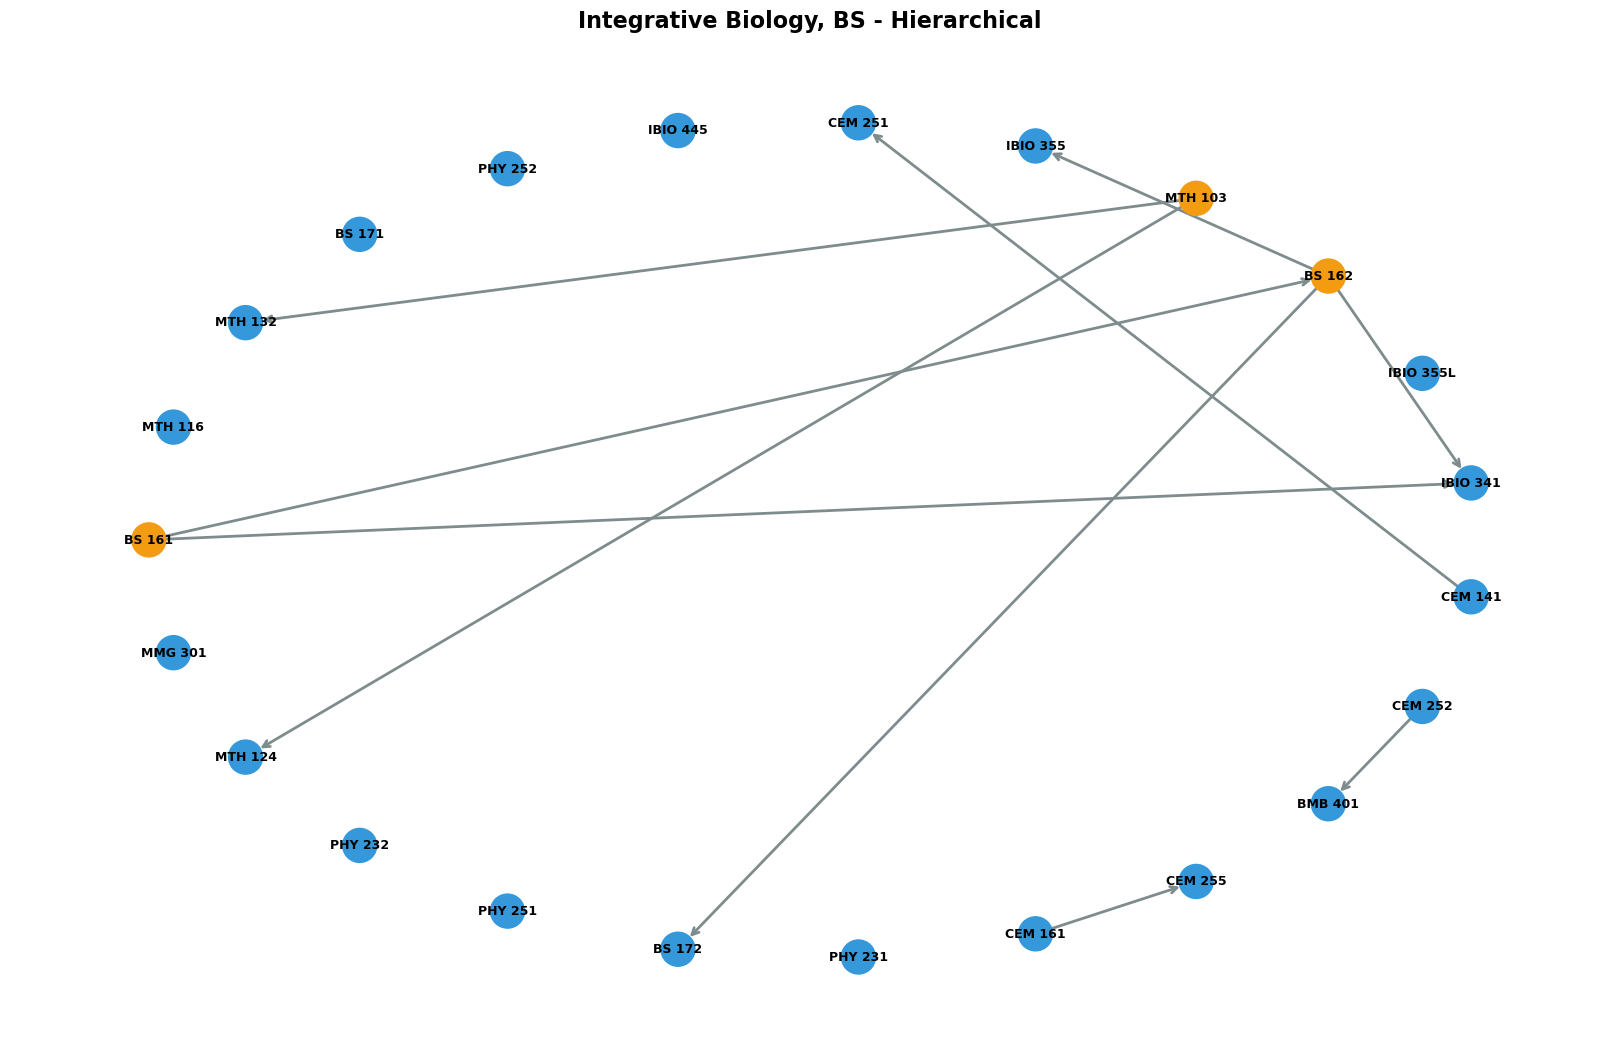

In [18]:
# Custom: Build and visualize any major
my_major = 'Integrative Biology, BS'  # Change this!

G = build_major_graph(data, my_major)
if G:
    print_graph_stats(G, my_major)
    display_graph_hierarchical(G, f"{my_major} - Hierarchical")
else:
    print(f"Major not found. Choose from:")
    list_majors(data)